#Stack Overflow topic modeling

Task 1: The given dataset is a table containing questions about R on StackOverflow site. Your first task is to perform standard text prepossessing steps introduced in lectures for future tasks. You can perform analysis on title or body of the questions.

Task 2: Using existing libraries, such as gensim https://radimrehurek.com/gensim/ to learn word embeddings from the prepossessed text from previous step. At the end of this step, you should save the learned word embeddings in a file.

Task 3: Perform topic analysis on the prepossessed textual data. Briefly specify how you pick the number of topics.

Present your findings (the final set of topics you extracted, the popularity of each topic).

##Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip /content/drive/MyDrive/Dataset/Data_Analytics/Questions.csv.zip

Archive:  /content/drive/MyDrive/Dataset/Data_Analytics/Questions.csv.zip
  inflating: Questions.csv           
  inflating: __MACOSX/._Questions.csv  


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/Questions.csv')

##Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189930 entries, 0 to 189929
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            189930 non-null  int64  
 1   OwnerUserId   188729 non-null  float64
 2   CreationDate  189930 non-null  object 
 3   Score         189930 non-null  int64  
 4   Title         189930 non-null  object 
 5   Body          189930 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.7+ MB


In [6]:
df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [7]:
df.isnull().sum()

Id                 0
OwnerUserId     1201
CreationDate       0
Score              0
Title              0
Body               0
dtype: int64

In [8]:
df.duplicated().any()

False

In [9]:
df.shape

(189930, 6)

##Data Preprocessing

In [10]:
import nltk
import re

In [11]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [13]:
#Text cleaning
stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    #remove whitespaces
    text = re.sub(r"\s+", " ", text)
    #remove tags
    text = re.sub(r"<[^>]+>", " ", text)
    #ASCII
    text = re.sub(r"[^A-Za-z]", " ", text)
    #remove SINGLECHAR
    text = re.sub(r"\b[A-Za-z]\b", " ", text)
    # remove links
    text = re.sub(r"http\S+", " ", text)
    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]
    words_filtered=[stemmer.stem(word) for word in words_tokens_lower if word not in stop_words]
    text_clean = ' '.join(words_filtered)
    return text_clean

In [14]:
df['Title_clean'] = df['Title'].apply(preprocess_text)
#df['Body_clean'] = df['Body'].apply(preprocess_text)

In [15]:
df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,Title_clean
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...,access last valu vector
1,79709,NaN,2008-09-17T03:39:16Z,3,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...,wors sin side effect pass massiv object
2,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...,explain quantil function
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...,test eof flag
4,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...,packag learn dirichlet prior count data


###word embeddings by gensim

Using existing libraries, such as gensim
 https://radimrehurek.com/gensim/ to learn word embeddings from the prepossessed text from previous step. At the end of this step, you should save the learned word embeddings in a file.

In [25]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from gensim.models import Word2Vec

In [27]:
import gensim
from gensim.utils import simple_preprocess

In [28]:
Title_clean_list = df['Title_clean'].tolist()

In [29]:
Title_clean_list

['access last valu vector',
 'wors sin side effect pass massiv object',
 'explain quantil function',
 'test eof flag',
 'packag learn dirichlet prior count data',
 'optim packag',
 'think vector',
 'vector think vector oper',
 'compil languag',
 'filter data',
 'oper time interv like',
 'easiest way instal file visual studio setup project',
 'csv file multipl time seri',
 'quot like oper like perl qw',
 'write gui brcapro cancer gene risk calcul engin',
 'sort axi barplot',
 'best practic handl time',
 'best way avoid pass data frame around',
 'function',
 'remov element list',
 'cumul plot given axi',
 'column store compar column base databas',
 'expens comput eigenvalu matrix',
 'color edg draw rect correct dendrogram',
 'random forest variabl import',
 'plot without titl label',
 'find row index contain maximum valu use',
 'calcul move averag',
 'suppress null devic output batch mode',
 'best way use script command line termin',
 'function paramet use without mention function bodi',

gensim.utils.simple_preprocess() fucntion

Gensim provide this function to convert a document into a list of lowercase tokens and also for ignoring tokens that are too short or too long. It has the following parameters −

doc(str)
It refers to the input document on which preprocessing should be applied.

deacc(bool, optional)
This parameter is used to remove the accent marks from tokens. It uses deaccent() to do this.

min_len(int, optional)
With the help of this parameter, we can set the minimum length of a token. The tokens shorter than defined length will be discarded.

max_len(int, optional)
With the help of this parameter we can set the maximum length of a token. The tokens longer than defined length will be discarded.

The output of this function would be the tokens extracted from input document.

In [30]:
def convert_text_into_listoftoken(text):
    for s in text:
        yield(gensim.utils.simple_preprocess(str(s), deacc=True))

In [31]:
Title_clean_list_token = list(convert_text_into_listoftoken(Title_clean_list)) 


In [32]:
Title_clean_list_token

[['access', 'last', 'valu', 'vector'],
 ['wors', 'sin', 'side', 'effect', 'pass', 'massiv', 'object'],
 ['explain', 'quantil', 'function'],
 ['test', 'eof', 'flag'],
 ['packag', 'learn', 'dirichlet', 'prior', 'count', 'data'],
 ['optim', 'packag'],
 ['think', 'vector'],
 ['vector', 'think', 'vector', 'oper'],
 ['compil', 'languag'],
 ['filter', 'data'],
 ['oper', 'time', 'interv', 'like'],
 ['easiest', 'way', 'instal', 'file', 'visual', 'studio', 'setup', 'project'],
 ['csv', 'file', 'multipl', 'time', 'seri'],
 ['quot', 'like', 'oper', 'like', 'perl', 'qw'],
 ['write', 'gui', 'brcapro', 'cancer', 'gene', 'risk', 'calcul', 'engin'],
 ['sort', 'axi', 'barplot'],
 ['best', 'practic', 'handl', 'time'],
 ['best', 'way', 'avoid', 'pass', 'data', 'frame', 'around'],
 ['function'],
 ['remov', 'element', 'list'],
 ['cumul', 'plot', 'given', 'axi'],
 ['column', 'store', 'compar', 'column', 'base', 'databas'],
 ['expens', 'comput', 'eigenvalu', 'matrix'],
 ['color', 'edg', 'draw', 'rect', 'corre

In [33]:
Title_clean_list_token[:10]

[['access', 'last', 'valu', 'vector'],
 ['wors', 'sin', 'side', 'effect', 'pass', 'massiv', 'object'],
 ['explain', 'quantil', 'function'],
 ['test', 'eof', 'flag'],
 ['packag', 'learn', 'dirichlet', 'prior', 'count', 'data'],
 ['optim', 'packag'],
 ['think', 'vector'],
 ['vector', 'think', 'vector', 'oper'],
 ['compil', 'languag'],
 ['filter', 'data']]

##Word Embedding

In [24]:
model = Word2Vec(Title_clean_list_token, min_count=1)

In [25]:
print(model)

Word2Vec<vocab=19164, vector_size=100, alpha=0.025>


In [26]:
words = list(model.wv.index_to_key)
print(words)

['data', 'use', 'column', 'valu', 'function', 'plot', 'frame', 'ggplot', 'error', 'row', 'variabl', 'packag', 'list', 'tabl', 'file', 'multipl', 'creat', 'vector', 'datafram', 'loop', 'matrix', 'shini', 'differ', 'name', 'time', 'base', 'two', 'get', 'number', 'group', 'string', 'one', 'object', 'line', 'date', 'chang', 'convert', 'find', 'condit', 'subset', 'set', 'charact', 'calcul', 'read', 'factor', 'add', 'extract', 'element', 'output', 'model', 'text', 'axi', 'remov', 'label', 'appli', 'work', 'new', 'code', 'match', 'select', 'within', 'anoth', 'dplyr', 'point', 'replac', 'return', 'result', 'specif', 'color', 'instal', 'make', 'combin', 'graph', 'regress', 'bar', 'run', 'csv', 'way', 'na', 'seri', 'format', 'count', 'argument', 'legend', 'geom', 'order', 'numer', 'map', 'mean', 'generat', 'without', 'merg', 'call', 'test', 'split', 'ad', 'dataset', 'sum', 'write', 'level', 'length', 'size', 'miss', 'predict', 'assign', 'input', 'scale', 'rstudio', 'non', 'load', 'random', 'save

In [27]:
model.save('model.bin')

In [28]:
new_model = Word2Vec.load('model.bin')

In [29]:
print(new_model)

Word2Vec<vocab=19164, vector_size=100, alpha=0.025>


In [30]:
#Visualising Word Embedding
#Plotting Word Vectors Using PCA
#retrieve all the vectors from a trained model
X_vectors = model.wv[model.wv.index_to_key]

In [31]:
from sklearn.decomposition import PCA

In [32]:
#create a 2-D PCA model of word vectors by using PCA class 
pca = PCA(n_components=2)
result = pca.fit_transform(X_vectors)

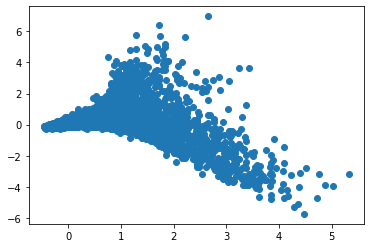

In [33]:
from matplotlib import pyplot
#plot the resulting projection by using the matplotlib
pyplot.scatter(result[:,0],result[:,1])

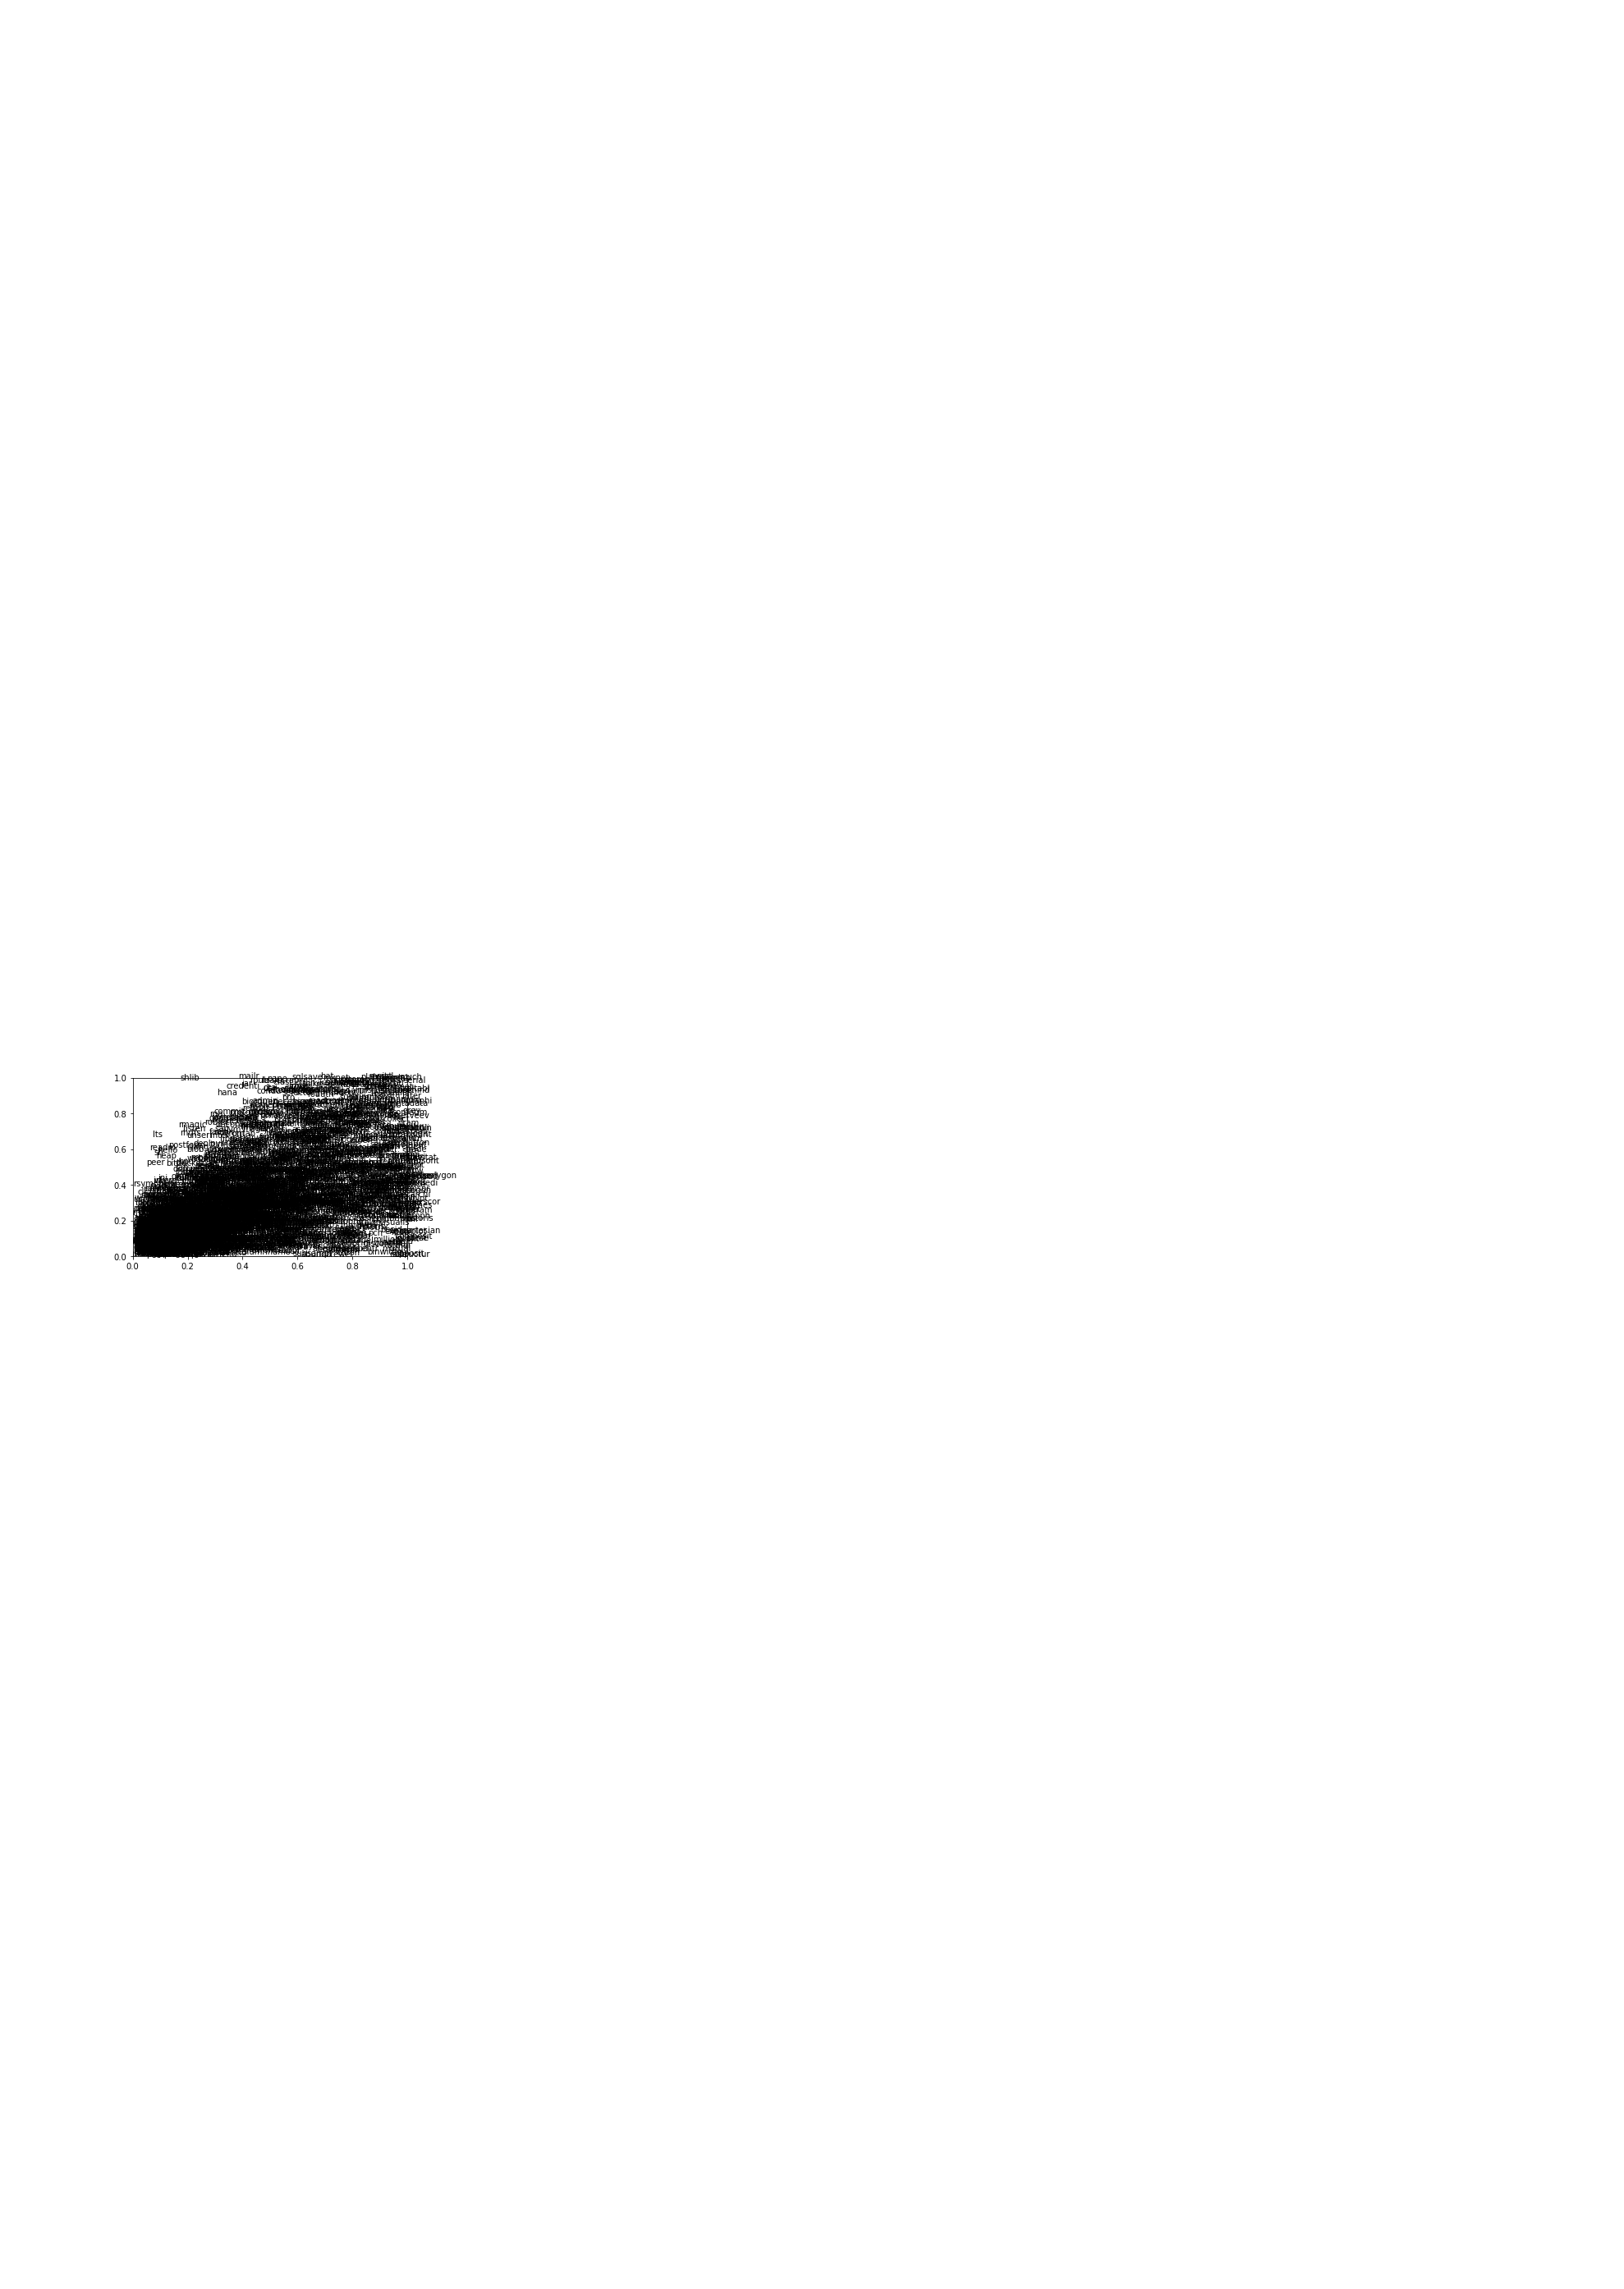

In [34]:
words = list(model.wv.index_to_key)
for i, word in enumerate(words):
  #annotate the points on the graph with the words itself
   pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()   


##Topic Modeling

In [34]:
from gensim import corpora
dictionary = corpora.Dictionary(Title_clean_list_token)
print(dictionary)

Dictionary<19164 unique tokens: ['access', 'last', 'valu', 'vector', 'effect']...>


In [35]:
import pprint

In [36]:
pprint.pprint(dictionary.token2id)

Streaming output truncated to the last 5000 lines.
 'rmoa': 12950,
 'rmongo': 5075,
 'rmongodb': 4498,
 'rmongodbhelp': 10256,
 'rmonkey': 14307,
 'rmoutlier': 12623,
 'rmpfr': 5748,
 'rmpi': 3905,
 'rmr': 7065,
 'rms': 3256,
 'rmse': 2378,
 'rmsle': 14998,
 'rmtrend': 15440,
 'rmultinom': 9582,
 'rmultireg': 16912,
 'rmvbin': 14293,
 'rmvlogi': 9259,
 'rmvnorm': 6900,
 'rmvpgibb': 13739,
 'rmysql': 1510,
 'rna': 8516,
 'rnaseq': 13188,
 'rnbinom': 15450,
 'rncep': 14560,
 'rneo': 9855,
 'rneoj': 14759,
 'rnetcdf': 2863,
 'rnetlogo': 5416,
 'rng': 6085,
 'rngscope': 15221,
 'rnn': 14708,
 'rnoaa': 8631,
 'rnobodi': 15599,
 'rnomad': 15086,
 'rnorm': 1693,
 'rnotebook': 17281,
 'rnvd': 6983,
 'rnw': 586,
 'ro': 18785,
 'road': 7577,
 'roadway': 14719,
 'roauth': 2535,
 'rob': 2906,
 'robcomposit': 16647,
 'robcov': 3954,
 'robdc': 3666,
 'robfilt': 7378,
 'robi': 18886,
 'robin': 8854,
 'robinson': 12883,
 'robit': 10295,
 'robj': 6123,
 'robject': 3248,
 'robust': 763,
 'robustbas': 17

In [37]:
#bag-of-word representation for a document
BoW_corpus = [dictionary.doc2bow(text) for text in Title_clean_list_token]
pprint.pprint(BoW_corpus)

Streaming output truncated to the last 5000 lines.
 [(221, 1), (259, 1), (1083, 1)],
 [(2, 1), (77, 1), (266, 1), (922, 1)],
 [(474, 1), (1014, 1), (3555, 1), (8732, 1), (19011, 1)],
 [(88, 1),
  (96, 1),
  (124, 1),
  (451, 1),
  (727, 1),
  (731, 1),
  (1164, 1),
  (2469, 1),
  (5423, 1)],
 [(68, 1), (133, 1), (695, 1)],
 [(18, 1), (64, 1), (197, 1), (490, 1), (642, 1)],
 [(18, 1), (31, 1), (42, 1), (168, 1), (401, 1), (543, 1), (555, 1), (1596, 1)],
 [(12, 1), (128, 1), (1230, 1)],
 [(7, 1), (38, 1), (239, 1), (328, 1), (840, 1), (5423, 1)],
 [(55, 1), (106, 1), (173, 1), (342, 1)],
 [(87, 1), (154, 1), (197, 1)],
 [(7, 1), (12, 1), (18, 1), (62, 1), (64, 1), (95, 1)],
 [(95, 1), (258, 1), (696, 1), (1052, 1), (7716, 1), (19012, 1)],
 [(70, 1), (154, 1), (188, 2), (345, 1), (633, 1)],
 [(12, 1),
  (18, 1),
  (64, 1),
  (70, 1),
  (95, 1),
  (262, 1),
  (279, 1),
  (810, 1),
  (1065, 1)],
 [(21, 1),
  (33, 1),
  (39, 1),
  (209, 1),
  (286, 1),
  (957, 1),
  (3302, 1),
  (19013, 1)],

In [38]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
print(id_words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
#Saving a Gensim Corpus
corpora.MmCorpus.serialize('/content/BoW_corpus.mm', BoW_corpus)

In [ ]:
#load the saved corpus
corpus_load = corpora.MmCorpus('/content/BoW_corpus.mm')
for line in corpus_load:
   print(line)

##LDA Topic Model

LDA’s approach to topic modeling is to classify text in a document to a particular topic.

LDA builds: A topic per document model and Words per topic model

After providing the LDA topic model algorithm, in order to obtain a good composition of topic-keyword distribution, it re-arrange − The topics distributions within the document and Keywords distribution within the topics


While processing, some of the assumptions made by LDA are −

Every document is modeled as multi-nominal distributions of topics.

Every topic is modeled as multi-nominal distributions of words.

We should have to choose the right corpus of data because LDA assumes that each chunk of text contains the related words.

LDA also assumes that the documents are produced from a mixture of topics.

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=BoW_corpus, id2word=dictionary, num_topics=20, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

In [42]:
#Viewing Topics in LDA Model
lda_model.print_topics()

[(0,
  '0.817*"use" + 0.056*"connect" + 0.038*"python" + 0.023*"version" + 0.021*"correct" + 0.012*"java" + 0.003*"hierarch" + 0.001*"ess" + 0.000*"error" + 0.000*"shini"'),
 (1,
  '0.000*"convertxi" + 0.000*"patter" + 0.000*"batteri" + 0.000*"codelit" + 0.000*"bioc" + 0.000*"patchi" + 0.000*"dmget" + 0.000*"arent" + 0.000*"biop" + 0.000*"safeuroot"'),
 (2,
  '0.219*"get" + 0.125*"subset" + 0.110*"factor" + 0.082*"level" + 0.075*"generat" + 0.065*"window" + 0.065*"scale" + 0.059*"custom" + 0.042*"distribut" + 0.038*"start"'),
 (3,
  '0.254*"file" + 0.244*"tabl" + 0.102*"set" + 0.092*"instal" + 0.089*"way" + 0.080*"read" + 0.033*"linear" + 0.027*"averag" + 0.014*"move" + 0.014*"languag"'),
 (4,
  '0.454*"plot" + 0.339*"ggplot" + 0.075*"axi" + 0.038*"larg" + 0.023*"second" + 0.019*"hour" + 0.010*"cumul" + 0.010*"minut" + 0.005*"etc" + 0.002*"resolut"'),
 (5,
  '0.393*"column" + 0.325*"valu" + 0.112*"base" + 0.024*"store" + 0.023*"print" + 0.022*"compar" + 0.021*"access" + 0.017*"program"

In [43]:
doc_lda = lda_model[BoW_corpus]

In [44]:
#Computing Model Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(BoW_corpus))


Perplexity:  -18.732455828573194


In [45]:
#Computing Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(
   model=lda_model, texts=Title_clean_list_token, dictionary=dictionary, coherence='u_mass'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -7.147669515603157


In [46]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e09ca26bf81a43f5bcd032bec6b3153e499291c559d985a8abba2b8b82585fb7
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=d1cfdc8b905b758626bfbf2193a0c5f188dd3aa1e7a74ce250596c934cc2c5ee
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [47]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [48]:
#Visualising the Topics-Keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, BoW_corpus, dictionary)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.190783 -0.380304       1        1  11.756292
5      0.165613  0.287846       2        1  10.250158
6      0.105337  0.034023       3        1   7.299043
12     0.105098  0.033831       4        1   7.101549
3      0.080746  0.019159       5        1   6.632342
9      0.075268  0.016838       6        1   6.481911
4      0.096932  0.027736       7        1   6.350839
0      0.078267  0.018162       8        1   6.246458
19     0.027932  0.003610       9        1   5.182152
2      0.034199  0.004818      10        1   5.011320
18     0.017384  0.001666      11        1   4.533479
16     0.003984 -0.000247      12        1   4.432281
17    -0.010216 -0.002153      13        1   4.205518
15    -0.023892 -0.003724      14        1   3.989550
14    -0.041577 -0.005366      15        1   3.315788
8     -0.097363 -0.009406      16        1   2.517119
13    -0.166306 -0.012087      17        1   1.782878
10    -0.161238 -0.011988      18        1   1.711748
11    -0.225058 -0.013015      19        1   1.165121
1     -0.255893 -0.009400      20        1   0.034452, topic_info=        Term          Freq         Total Category  logprob  loglift
96       use  53765.000000  53765.000000  Default  30.0000  30.0000
18      data  57022.000000  57022.000000  Default  29.0000  29.0000
70    column  42426.000000  42426.000000  Default  28.0000  28.0000
68      plot  30362.000000  30362.000000  Default  27.0000  27.0000
12  function  31899.000000  31899.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
25      oper      0.018945   2228.203726  Topic20  -9.8608  -3.7018
26    compil      0.018945    610.808253  Topic20  -9.8608  -2.4076
27   languag      0.018945    973.450962  Topic20  -9.8608  -2.8737
28    filter      0.018945   4579.466038  Topic20  -9.8608  -4.4222
29    interv      0.018945   2900.141705  Topic20  -9.8608  -3.9654

[941 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.999261     access
145       6  0.999736        add
122       9  0.999320     aggreg
138       3  0.998188  algorithm
248       5  0.991825      alpha
...     ...       ...        ...
143       3  0.999101     weight
224      10  0.999577     window
245       9  0.999644     within
90       16  0.999627    without
53       19  0.999380      write

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 13, 4, 10, 5, 1, 20, 3, 19, 17, 18, 16, 15, 9, 14, 11, 12, 2])

In [50]:
#Finding Optimal Number of Topics for LDA\
from gensim.models import CoherenceModel
def coherence_perplexity_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
   perplexity_list=[]
   coherence_values = []
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(
        corpus=BoW_corpus, id2word=dictionary, num_topics=num_topics, random_state=100, 
        update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
         )
      model_list.append(model)
      perplexity_list.append(model.log_perplexity(corpus))
      coherencemodel = CoherenceModel(
      model=model, texts=texts, dictionary=dictionary, coherence='u_mass'
      )
      coherence_values.append(coherencemodel.get_coherence())
   return model_list, coherence_values,perplexity_list

In [53]:
model_list, coherence_values,perplexity_list = coherence_perplexity_values_computation (
   dictionary=dictionary, corpus=BoW_corpus, texts=Title_clean_list_token, 
   start=1, limit=50, step=8
)


In [55]:
import matplotlib.pyplot as plt

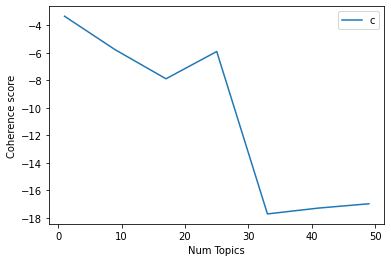

In [56]:
limit=50; start=1; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [58]:
for m, cv in zip(x, perplexity_list):
   print("Num Topics =", m, " is having perplexity Value of", round(cv, 4))

Num Topics = 1  is having perplexity Value of -6.879
Num Topics = 9  is having perplexity Value of -7.1601
Num Topics = 17  is having perplexity Value of -15.6593
Num Topics = 25  is having perplexity Value of -21.3002
Num Topics = 33  is having perplexity Value of -25.5975
Num Topics = 41  is having perplexity Value of -30.3341
Num Topics = 49  is having perplexity Value of -35.2507


In [57]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 1  is having Coherence Value of -3.3537
Num Topics = 9  is having Coherence Value of -5.789
Num Topics = 17  is having Coherence Value of -7.8957
Num Topics = 25  is having Coherence Value of -5.9146
Num Topics = 33  is having Coherence Value of -17.709
Num Topics = 41  is having Coherence Value of -17.2876
Num Topics = 49  is having Coherence Value of -16.9721


In [60]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(6, '0.493*"output" + 0.204*"pdf" + 0.096*"null" + 0.024*"batch" + 0.024*"devic" + 0.021*"mode" + 0.016*"rscript" + 0.010*"suppress" + 0.000*"error" + 0.000*"shini"'), (11, '0.767*"loop" + 0.147*"larg" + 0.001*"prefer" + 0.000*"error" + 0.000*"shini" + 0.000*"name" + 0.000*"extract" + 0.000*"nest" + 0.000*"work" + 0.000*"two"'), (17, '0.372*"find" + 0.161*"librari" + 0.089*"exist" + 0.086*"build" + 0.058*"process" + 0.057*"link" + 0.049*"option" + 0.035*"quot" + 0.016*"rearrang" + 0.000*"error"'), (22, '0.210*"without" + 0.168*"scale" + 0.154*"custom" + 0.107*"paramet" + 0.100*"start" + 0.088*"histogram" + 0.077*"break" + 0.015*"logarithm" + 0.004*"gui" + 0.000*"error"'), (10, '0.348*"set" + 0.344*"add" + 0.130*"excel" + 0.088*"like" + 0.012*"alpha" + 0.000*"error" + 0.000*"shini" + 0.000*"name" + 0.000*"condit" + 0.000*"date"'), (24, '0.437*"number" + 0.252*"way" + 0.053*"avoid" + 0.047*"increas" + 0.042*"best" + 0.033*"tab" + 0.031*"linux" + 0.019*"around" + 0.015*"region" + 0.004*"